In [1]:
import classifiers.labeller as labeller
import classifiers.arima as arima
import nn_train_driver
import plotting.plot_shortcuts as ps
# import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

Computing Label Space...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:02<00:00, 91.49it/s]


      EpochTime  Label  Label_Signal
0  1.641220e+09    1.0    400.144678
1  1.641220e+09    1.0    400.259335
2  1.641220e+09    1.0    400.337566
3  1.641220e+09    1.0    400.437786
4  1.641220e+09    1.0    400.558764


<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/matplotlib/pyplot.py'>

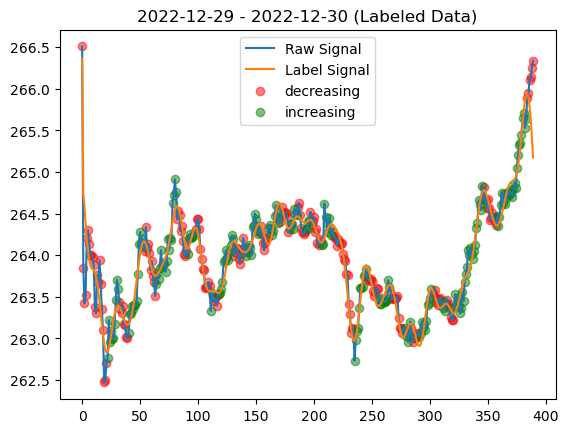

In [2]:
# read in data
data_df = pd.read_csv('./data/qqq_2022.csv')

# produce truth labels
print('Computing Label Space...')
label_df = labeller.driver(data_df, 21, 'Close')
print(label_df.head())

# plot data/labels/label signal
sig_col = 'Close'
forecast_sig_col = 'Forecast ' + sig_col
ps.plot_label_over_signal(data_df.iloc[-390:], label_df.iloc[-390:], sig_col, 'Labeled Data')

#### Labelling Explanation

Stock Market data is very noisy, and is often likened to "random walks". Because of this, computing outright price differentials (price_t - price_t-1) will not result in coherent/noiseless data. So, some form of "truth" data must be computed.

In order to best classify the direction of the market's movement, the following process was conducted to compute "truth" data:

1. To account for growth, the coefficients of the following exponential function were optimized to the data:
$\newline$
$y = Ax^B + C$
$\newline$

2. To account for fluctuations around the exponential function, an FFT was computed on the following price values:
$\newline$
$clean\_signal = FFT(raw\_data - growth\_model)$
$\newline$

3. Produce a clean version of the market data:
$\newline$
$clean\_market\_signal = growth\_model + clean\_signal$
$\newline$

4. Compute Velocity of clean market data
$\newline$
$ velocity = \frac{\delta clean\_market\_signal}{\delta t}$
$\newline$

5. Compute Labels from Velocity
$\newline$
$ y = 0;\space velocity < 0 \newline$
$ y = 1;\space velocity > 0$

# Neural Net Assessments

## MLP

MLP Hyperparameter Configuration:
{'activation': 'softmax',
 'epochs': 3,
 'in_shape': 18,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'n_fft_components': 8,
 'out_shape': 2,
 'periods': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'signal_data_column': 'Close'}

Training MLP:


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,170 (4.57 KB)

 Trainable params: 1,170 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 1s 225us/step - accuracy: 0.6891 - loss: 0.5923
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - accuracy: 0.6932 - loss: 0.5842
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - accuracy: 0.6958 - loss: 0.5794
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step

Test Space Classification Report (MLP):
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      9245
         1.0       0.70      0.69      0.70      9548

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/matplotlib/pyplot.py'>

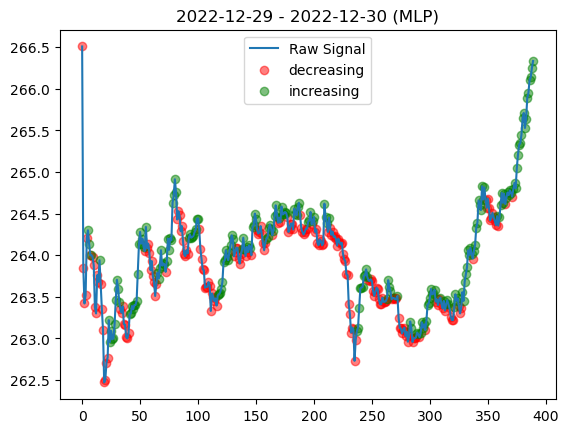

In [3]:
# use the default config file for building/training the Multilayer Perceptron
nn_config = nn_train_driver.default_training_config()
print(f'MLP Hyperparameter Configuration:')
pprint(nn_config)

# build/train the MLP
print('\nTraining MLP:')
mlp, mlp_test_df = nn_train_driver.train_mlp(data_df, label_df=label_df, config=nn_config)

# format the test df to just be the feature space
feature_cols = list(mlp_test_df.columns)
feature_cols.remove('EpochTime')
feature_cols.remove('Label')

# get the properly formatted test space
y_test_true = mlp_test_df['Label']
yhat_test = nn_train_driver.inverse_onehot(mlp.predict(mlp_test_df[feature_cols]))
print(f'\nTest Space Classification Report (MLP):\n{classification_report(y_test_true, yhat_test)}')

# plot the MLP classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': mlp_test_df['EpochTime'].values,
                             'Label': yhat_test})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close', 'MLP')

## LSTM

LSTM Hyperparameter Configuration:
{'activation': 'softmax',
 'epochs': 3,
 'in_shape': 18,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'n_fft_components': 8,
 'out_shape': 2,
 'periods': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'signal_data_column': 'Close'}

Training LSTM:


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,202 (47.66 KB)

 Trainable params: 12,202 (47.66 KB)

 Non-trainable params: 0 (0.00 B)

None
(75171, 18)
(75171, 2)
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6679 - loss: 0.6070
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6734 - loss: 0.5968
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6747 - loss: 0.5930
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step

Test Space Classification Report (LSTM):
              precision    recall  f1-score   support

         0.0       0.66      0.75      0.70      9245
         1.0       0.72      0.62      0.66      9548

    accuracy                           0.68     18793
   macro avg       0.69      0.68      0.68     18793
weighted avg       0.69      0.68      0.68     18793



<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/matplotlib/pyplot.py'>

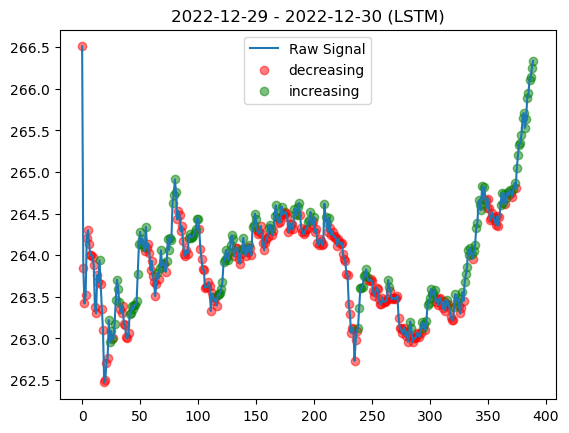

In [4]:
# use the default config file for building/training the Multilayer Perceptron
nn_config = nn_train_driver.default_training_config()
print(f'LSTM Hyperparameter Configuration:')
pprint(nn_config)

# build/train the LSTM
print('\nTraining LSTM:')
lstm, lstm_test_df = nn_train_driver.train_lstm(data_df, label_df=label_df, config=nn_config)

# format the test df to just be the feature space
feature_cols = list(lstm_test_df.columns)
feature_cols.remove('EpochTime')
feature_cols.remove('Label')

# get the properly formatted test space
y_test_true = lstm_test_df['Label']
yhat_test = nn_train_driver.inverse_onehot(lstm.predict(lstm_test_df[feature_cols]))
print(f'\nTest Space Classification Report (LSTM):\n{classification_report(y_test_true, yhat_test)}')

# plot the LSTM classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': lstm_test_df['EpochTime'].values,
                             'Label': yhat_test})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close', 'LSTM')

## CNN

CNN Hyperparameter Configuration:
{'activation': 'softmax',
 'epochs': 3,
 'in_shape': 18,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'n_fft_components': 8,
 'out_shape': 2,
 'periods': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'signal_data_column': 'Close'}

Training CNN:


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 100)        │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         2,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,402 (13.29 KB)

 Trainable params: 3,402 (13.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step - accuracy: 0.6447 - loss: 0.6330
Epoch 2/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step - accuracy: 0.6740 - loss: 0.6064
Epoch 3/3
2350/2350 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.6801 - loss: 0.6001
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step

Test Space Classification Report (CNN):
              precision    recall  f1-score   support

         0.0       0.77      0.45      0.57      9245
         1.0       0.62      0.87      0.73      9548

    accuracy                           0.67     18793
   macro avg       0.70      0.66      0.65     18793
weighted avg       0.70      0.67      0.65     18793



<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/matplotlib/pyplot.py'>

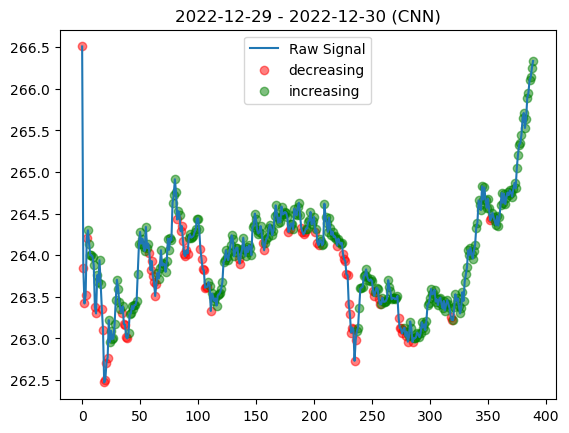

In [5]:
# use the default config file for building/training the Multilayer Perceptron
nn_config = nn_train_driver.default_training_config()
print(f'CNN Hyperparameter Configuration:')
pprint(nn_config)

# build/train the CNN
print('\nTraining CNN:')
cnn, cnn_test_df = nn_train_driver.train_cnn(data_df, label_df=label_df, config=nn_config)

# format the test df to just be the feature space
feature_cols = list(cnn_test_df.columns)
feature_cols.remove('EpochTime')
feature_cols.remove('Label')

# get the properly formatted test space
y_test_true = cnn_test_df['Label']
yhat_test = nn_train_driver.inverse_onehot(cnn.predict(cnn_test_df[feature_cols]))
print(f'\nTest Space Classification Report (CNN):\n{classification_report(y_test_true, yhat_test)}')

# plot the CNN classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': cnn_test_df['EpochTime'].values,
                             'Label': yhat_test})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close', 'CNN')

# ARIMA Assessment

## Choosing ARIMA Order

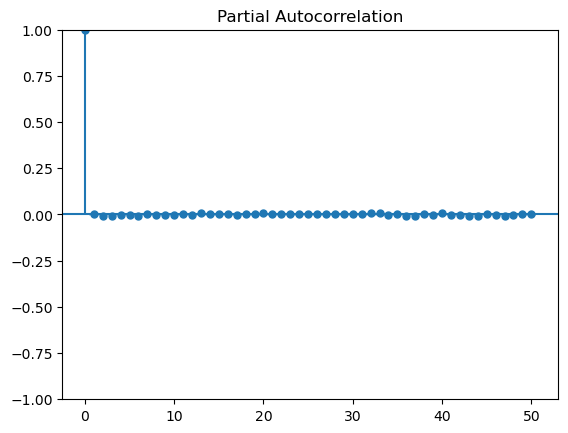

In [6]:
# The pacf and acf plots below are plotted twice due to an incompatability
# between the stats package and jupyter notebooks. Adding a semicolon to the
# end of the line solves the problem: https://github.com/statsmodels/statsmodels/issues/4155#issuecomment-445913264
plot_pacf(data_df[[sig_col]].diff().dropna());
p = 1

Given the spike at 1 with the values significantly dropping off and staying around 0, we use 1 as the initial autoregression param

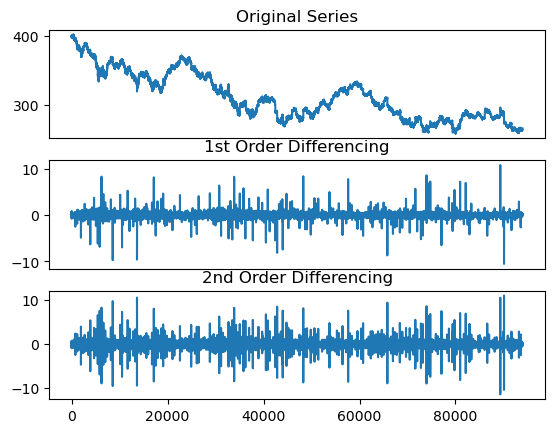

In [7]:
ps.plot_data_differencing(data_df, sig_col)
d = 1

Because the data appears relatively stabilized after a first order difference, we use that as the d param

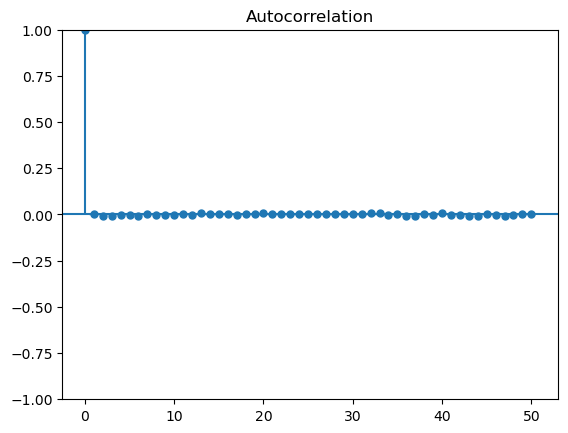

In [8]:
plot_acf(data_df[[sig_col]].diff().dropna());
q = 1

Given the spike at 1 with the values significantly dropping off and staying around 0, we use 1 as the initial moving average param

## Evaluating ARIMA w/ Minute Forecasting

In [9]:
# filter data on the times from the test df above to cut down on run time.
# Running on the full "test_df" still takes about 15 mins
arima_minute_forecast_df = data_df.loc[np.in1d(data_df.EpochTime, mlp_test_df.EpochTime)]

# fit/forecast ARIMA
price_column = 'Open'
minute_forecast_df = arima.minute_forecast(arima_minute_forecast_df, sig_col=price_column)

  0%|                                                                                                                                                                                       | 0/18673 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [ ]:
# classify the arima forecasts as increasing or decreasing
arima_yhat = arima.convert_forecast_to_classification(minute_forecast_df[f'Forecast {price_column}'].values)
arima_yhat_df = pd.DataFrame({'EpochTime': minute_forecast_df.EpochTime.iloc[1:],
                              'Label': arima_yhat})

# generate classification report
print(f'\nARIMA Classification Report:')
print(classification_report(test_df.Label.values[-arima_yhat.shape[0]:], 
                            arima_yhat))

# plot the ARIMA diff overtop the raw prices for the final day (390 minutes) in the DF
ps.plot_label_over_signal(data_df.iloc[-390:], arima_yhat_df.iloc[-390:], 'Close')

## Evaluating ARIMA w/ Daily Forecasting

In [ ]:
# adjusts the index of the data to a date-timestamp using the epoch time column
date_indexed_df = arima.index_df_by_date(data_df)

# extract the true day values for ARIMA evaluation
true_values = arima.get_arima_true_values(date_indexed_df, sig_col)

# fit the model with the p,d,q variables and forecast the next data point
forecast_df = arima.day_forecast(date_indexed_df, sig_col, p, d, q)

# merge the actual and forecast data together on the day
arima_df = pd.merge(true_values, forecast_df, left_index=True, right_index=True)
arima_df = arima_df.rename(columns={1: forecast_sig_col})

# plot the actual vs forecast values
ps.plot_forecast(arima_df, sig_col, forecast_sig_col, 10)